In [ ]:
# %%

import torchsummary as summary
import librosa
import matplotlib.pyplot as plt
import soundfile as sf
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from data.config import *
from data.utils import *
# from data.dataset import MixtureDataset, AudioMixtureDataset
from data.dataset import AudioDataset
from tqdm import tqdm
from torchlibrosa.stft import STFT, ISTFT, magphase
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import train_test_split
from metrics_loss import *

# load neccessary metrics/confusion matrix for multilabel classification
from sklearn.metrics import multilabel_confusion_matrix, classification_report

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# mp.set_start_method('spawn', force=True)

# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# os.environ['TORCH_USE_CUDA_DSA'] = '1'

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c, stride=1):
        super(ResidualBlock, self).__init__()

        self.residual_block = nn.Sequential(
            nn.BatchNorm2d(in_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=stride, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(
            in_c, out_c, kernel_size=1, stride=stride, padding=0)

    def forward(self, inputs):
        x = self.residual_block(inputs)
        s = self.shortcut(inputs)

        skip = x + s
        return skip


class DecoderBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super(DecoderBlock, self).__init__()
        self.upsampling = nn.ConvTranspose2d(
            in_c, out_c, kernel_size=2, stride=2, padding=0, dilation=1)
        self.residual_block = ResidualBlock(
            out_c * 2, out_c)
        # self.upsampling = nn.Upsample(
        #     scale_factor=2, mode='bilinear', align_corners=True)
        # self.residual_block = ResidualBlock(
        #     in_c + out_c, out_c)

    def forward(self, x, skip):
        # Upsample
        x = self.upsampling(x)
        # Ensure x and skip have the same spatial dimensions
        if x.shape[2:] != skip.shape[2:]:
            x = F.interpolate(
                x, size=(skip.shape[2], skip.shape[3]), mode='bilinear', align_corners=True)

        # Concatenate
        x = torch.cat([x, skip], dim=1)

        # Residual block
        x = self.residual_block(x)

        return x


class ResUNet(nn.Module):
    def __init__(self, in_c, out_c):
        super(ResUNet, self).__init__()

        """ Encoder 1 """
        self.encoder_block1 = nn.Sequential(
            nn.Conv2d(in_c, out_c,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(out_c, out_c,
                      kernel_size=3, stride=1, padding=1),
        )

        """ Shortcut Connection """
        self.shortcut = nn.Conv2d(in_c, out_c, kernel_size=1, padding=0)

        """ Encoder 2 and 3"""
        self.encoder_block2 = ResidualBlock(
            out_c, out_c * 2, stride=2)
        self.encoder_block3 = ResidualBlock(
            out_c * 2, out_c * 4, stride=2)

        """ Bridge """
        self.bridge = ResidualBlock(
            out_c * 4, out_c * 8, stride=2)

        """ Decoder """
        self.decoder_block1 = DecoderBlock(out_c * 8, out_c * 4)
        self.decoder_block2 = DecoderBlock(out_c * 4, out_c * 2)
        self.decoder_block3 = DecoderBlock(out_c * 2, out_c)

        """ Output """
        self.output = nn.Sequential(
            nn.Conv2d(out_c, 3, kernel_size=1, padding=0),
        )

        self.classifier = nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(out_c*4, out_c*2, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.ReLU(),

            # Linear
            nn.Flatten(),
            nn.Linear(out_c*2 * 8 * 30, out_c*2),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(out_c*2, out_c),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(out_c, 8)
        )

    def forward(self, x):

        x = x.unsqueeze(1)

        """ Encoder 1 """
        encoder1 = self.encoder_block1(x)
        s = self.shortcut(x)
        skip1 = encoder1 + s

        """ Encoder 2 and 3 """
        skip2 = self.encoder_block2(skip1)
        skip3 = self.encoder_block3(skip2)

        """ Bridge """
        bridge = self.bridge(skip3)

        """ Decoder """
        decoder1 = self.decoder_block1(bridge, skip3)
        decoder2 = self.decoder_block2(decoder1, skip2)
        decoder3 = self.decoder_block3(decoder2, skip1)

        """ Output """
        output = self.output(decoder3)

        output_masks_dict = {
            'mag_mask': torch.sigmoid(output[:, 0, :, :]),
            'real_mask': torch.tanh(output[:, 1, :, :]),
            'imag_mask': torch.tanh(output[:, 2, :, :])
        }

        class_output = self.classifier(skip3)
        # return output, class_output
    
        return output_masks_dict, class_output

In [ ]:
# %%

# Define the multi-task loss function


def multi_task_loss(separation_output, classification_output, true_percussion, true_class, alpha=0.7, beta=0.3, spectrogram_loss=False):

    if spectrogram_loss == False:
        mse_loss = nn.MSELoss()
        separation_loss = mse_loss(separation_output, true_percussion)

    else:
        separation_loss = spectral_loss(separation_output, true_percussion)

    # classification_loss = nn.CrossEntropyLoss()(classification_output, true_class)
    classification_loss = nn.BCEWithLogitsLoss()(classification_output, true_class)

    loss = alpha * separation_loss + beta * classification_loss

    return loss

In [ ]:
# %%

# Load metadata
metadata = pd.read_csv(os.path.join(
    DATASET_MIX_AUDIO_PATH, "metadata.csv"))

# define the train, validation and test sets

# dataset = MixtureDataset(metadata_file=metadata, k=0.6,
#                          noise_class=None)
# dataset = AudioMixtureDataset(metadata_file=metadata, k=0.4,
#                               noise_class='siren')
# dataset = AudioMixtureDataset(metadata_file=metadata, k=None, noise_class=None)

# dataset = AudioDataset(metadata_file=metadata, noise_classes=[
#                                           'engine_idling', 'air_conditioner'], random_noise=True)
dataset = AudioDataset(metadata_file=metadata, random_noise=True)

In [ ]:
# %%

# when using the saved indices
train_indices = np.load('train_indices.npy')
val_indices = np.load('val_indices.npy')
test_indices = np.load('test_indices.npy')

# train_indices = np.load('train_indices_engine_air.npy')
# val_indices = np.load('val_indices_engine_air.npy')
# test_indices = np.load('test_indices_engine_air.npy')

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

# train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)
# val_loader = DataLoader(dataset, sampler=val_sampler,
#                         batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)
# test_loader = DataLoader(dataset, sampler=test_sampler,
#                          batch_size=32, num_workers=2, persistent_workers=True, prefetch_factor=2)

train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=20)
val_loader = DataLoader(dataset, sampler=val_sampler, batch_size=20)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=12)

In [ ]:
# %%

class SpectrogramReconstructor:
    def __init__(self):
        pass

    def magphase(self, real, imag):
        mag = (real ** 2 + imag ** 2) ** 0.5
        cos = real / torch.clamp(mag, 1e-10, np.inf)
        sin = imag / torch.clamp(mag, 1e-10, np.inf)

        return mag, cos, sin

    def reconstruct(self, mag_mask, real_mask, imag_mask, mix_stft):

        mix_mag, mix_cos, mix_sin = self.magphase(mix_stft.real, mix_stft.imag)
        _, mask_cos, mask_sin = self.magphase(real_mask, imag_mask)

        # calculate the |Y| = |M| * |X|
        estimated_mag = mag_mask * mix_mag

        # Reconstruct the complex spectrogram
        Y_real = estimated_mag * (mask_cos * mix_cos - mask_sin * mix_sin)
        Y_imag = estimated_mag * (mask_cos * mix_sin + mask_sin * mix_cos)
        sep_output = torch.complex(Y_real, Y_imag)

        return sep_output


# ISTFT conversion function


def istft(sep_output, n_fft, hop_length):

    y = torch.istft(
        sep_output, n_fft, hop_length, window=torch.hann_window(256, device='cuda'), length=31248)

    return y

In [ ]:
# %%

# Define the model, optimizer and loss function
# model = MultiTaskResUNet(num_noise_classes=8).to("cuda")
model = ResUNet(in_c=1, out_c=16).to("cuda")
optimizer = AdamW(model.parameters(), lr=0.001, amsgrad=True)
# optimizer = AdamW(model.parameters(), lr=0.001)
criterion = multi_task_loss
device = "cuda"

In [ ]:
# %%

# Train the model

train_losses = []
val_losses = []
best_val_loss = np.inf
patience = 5
num_epochs = 5

Epoch 1/5 Validation Loss: 1.1658: 100%|██████████| 194/194 [04:33<00:00,  1.41s/it]


Epoch 1/5 Validation Loss: 1.1658, Validation Accuracy: 0.7130


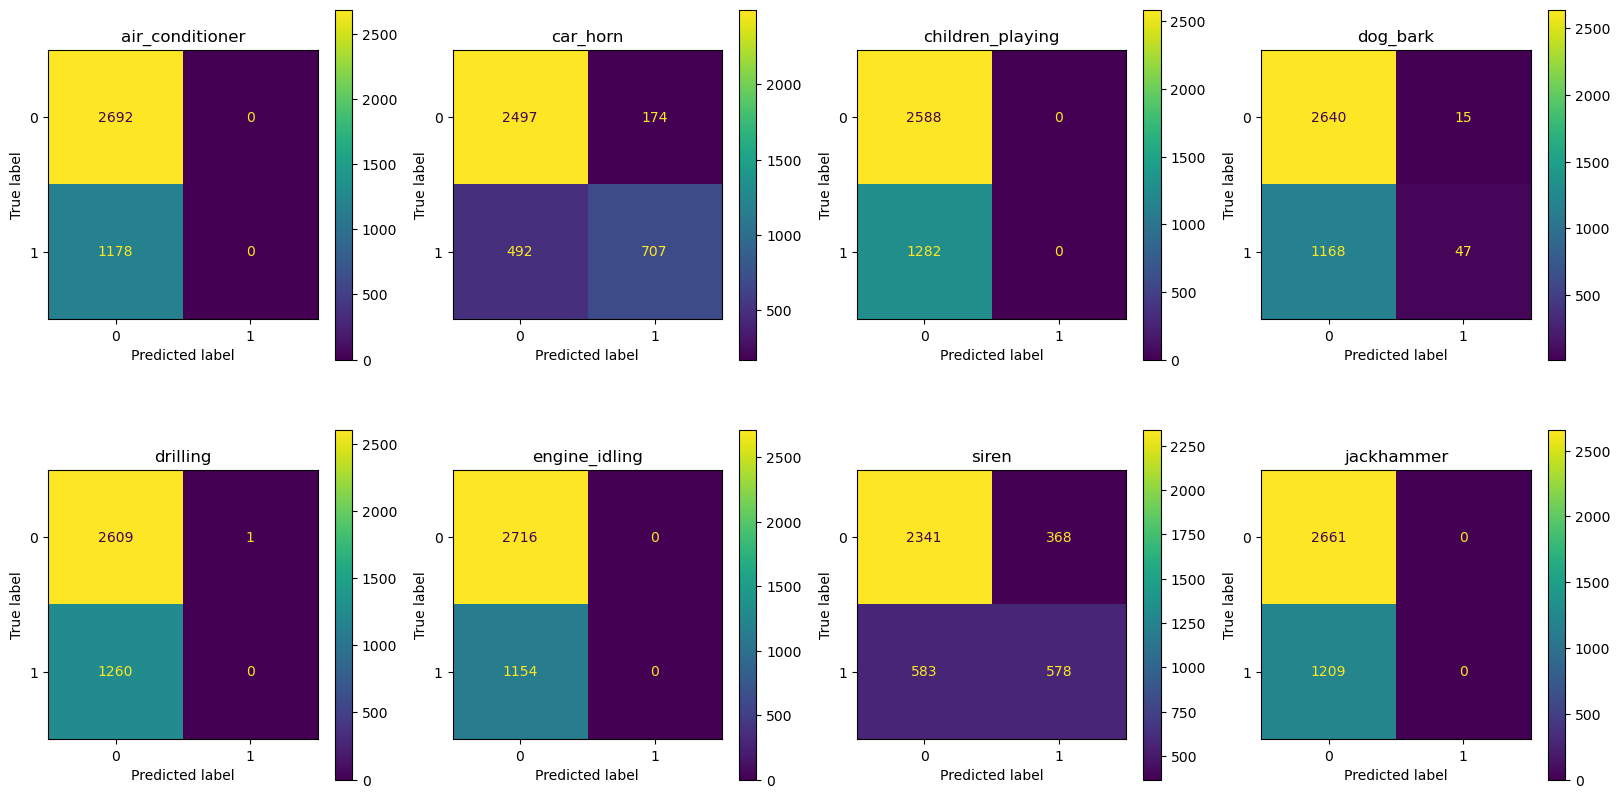

c:\Users\jejep\anaconda3\envs\ProjectEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jejep\anaconda3\envs\ProjectEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

 air_conditioner       0.00      0.00      0.00      1178
        car_horn       0.80      0.59      0.68      1199
children_playing       0.00      0.00      0.00      1282
        dog_bark       0.76      0.04      0.07      1215
        drilling       0.00      0.00      0.00      1260
   engine_idling       0.00      0.00      0.00      1154
           siren       0.61      0.50      0.55      1161
      jackhammer       0.00      0.00      0.00      1209

       micro avg       0.70      0.14      0.23      9658
       macro avg       0.27      0.14      0.16      9658
    weighted avg       0.27      0.14      0.16      9658
     samples avg       0.33      0.14      0.19      9658

Checkpoint saved at 'checkpoint\checkpoint_spectralv1_epoch_0'
Model improved. Saving the model...


Epoch 2/5 Validation Loss: 1.3270: 100%|██████████| 194/194 [01:45<00:00,  1.83it/s]


Epoch 2/5 Validation Loss: 1.3270, Validation Accuracy: 0.7315


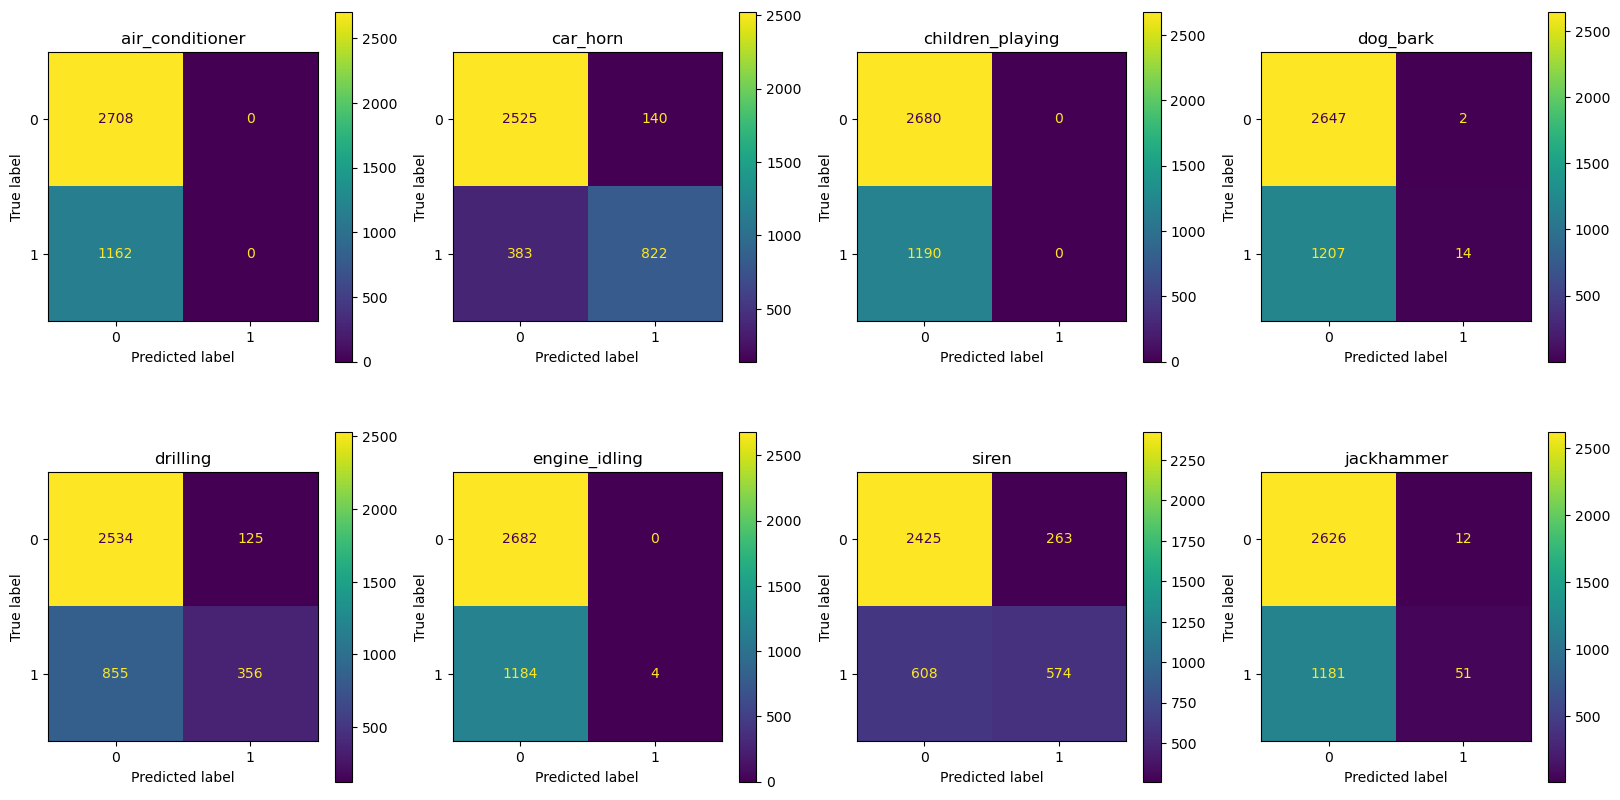

c:\Users\jejep\anaconda3\envs\ProjectEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\jejep\anaconda3\envs\ProjectEnv\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                  precision    recall  f1-score   support

 air_conditioner       0.00      0.00      0.00      1162
        car_horn       0.85      0.68      0.76      1205
children_playing       0.00      0.00      0.00      1190
        dog_bark       0.88      0.01      0.02      1221
        drilling       0.74      0.29      0.42      1211
   engine_idling       1.00      0.00      0.01      1188
           siren       0.69      0.49      0.57      1182
      jackhammer       0.81      0.04      0.08      1232

       micro avg       0.77      0.19      0.30      9591
       macro avg       0.62      0.19      0.23      9591
    weighted avg       0.62      0.19      0.23      9591
     samples avg       0.47      0.19      0.27      9591

Checkpoint saved at 'checkpoint\checkpoint_spectralv1_epoch_1'


Epoch 3/5 Training Loss: 1.0850:   1%|▏         | 8/581 [00:05<06:23,  1.49it/s]


KeyboardInterrupt: 

In [ ]:
#%%

# model, optimizer, start_epoch, loss = load_checkpoint(model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_air_engine_epoch_3.pth')
# model, optimizer, start_epoch, loss = load_checkpoint(model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_air_engine_spectralv1_epoch_2.pth')
# model, optimizer, start_epoch, loss = load_checkpoint(
#     model, optimizer, checkpoint_dir='checkpoint', filename='checkpoint_spectral_epoch_2.pth')

start_epoch = 0

for epoch in range(start_epoch, num_epochs):
    model.train()
    train_loss = 0 
    train_bar = tqdm(train_loader, desc=f"Epoch {
                     epoch + 1}/{num_epochs} Training Loss: {train_loss:.4f}", colour='green')
    for i, batch in enumerate(train_bar):
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Move data to device
        # mixture = batch['mixture_audio'].to(device)
        # true_percussion = batch['percussion_audio'].to(device)
        mix_stft = batch['mix_stft'].to(device)
        true_percussion_stft = batch['perc_stft'].to(device)

        # true_class = batch['noise_class'].to(device)
        # ici true class est un tensor de taille (batch_size, 8) avec des 0 et des 1 pour les classes présentes et absentes
        true_class = batch['noise_labels'].to(device)

        # Forward pass
        output, class_output = model(torch.abs(mix_stft))

        # Reconstruct the complex spectrogram
        sep_output = SpectrogramReconstructor().reconstruct(
            output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
        # percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

        # Calculate the loss
        # loss = criterion(percussion_sep, class_output, true_percussion, true_class)
        loss = criterion(sep_output, class_output, true_percussion_stft,
                         true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

        # Backward pass
        loss.backward()
        optimizer.step()

        # else we calculate log spectral loss so we need to calculate the stft of the separated percussion (sep_output is the complex spectrogram of the separated percussion)
        # true_percussion_stft = torch.stft(true_percussion, n_fft=256, hop_length=64, win_length=256, window=torch.hann_window(window_length=256, device=device), return_complex=True)

        train_loss += loss.item()
        train_bar.set_description(
            f"Epoch {epoch + 1}/{num_epochs} Training Loss: {train_loss/(i+1):.4f}")

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0
    
    # confusion matrix for multilabel classification
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    val_bar = tqdm(val_loader, desc=f"Epoch {
        epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}", colour='red')
    with torch.no_grad():
        for i, batch in enumerate(val_bar):
            # Move data to device
            # mixture = batch['mixture_audio'].to(device)
            mix_stft = batch['mix_stft'].to(device)
            # true_percussion = batch['percussion_audio'].to(device)
            true_percussion_stft = batch['perc_stft'].to(device)
            true_class = batch['noise_labels'].to(device)

            # Forward pass
            output, class_output = model(torch.abs(mix_stft))

            # Reconstruct the complex spectrogram
            sep_output = SpectrogramReconstructor().reconstruct(
                output['mag_mask'], output['real_mask'], output['imag_mask'], mix_stft)
            # percussion_sep = istft(sep_output, n_fft=256, hop_length=64)

            # Calculate the loss
            # loss = criterion(percussion_sep, class_output, true_percussion, true_class)
            loss = criterion(sep_output, class_output, true_percussion_stft,
                             true_class, alpha=0.7, beta=0.3, spectrogram_loss=True)

            val_loss += loss.item()
            
            # Calculate multi-label classification accuracy
            predicted = (torch.sigmoid(class_output) > 0.5).float()
            # Total for a multi-label classification:
            total += true_class.size(0) * true_class.size(1)
            correct += (predicted == true_class).float().sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(true_class.cpu().numpy())
            
            val_bar.set_description(
                f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss/(i+1):.4f}")
            
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        accuracy = correct / total
        
        print(f"Epoch {epoch + 1}/{num_epochs} Validation Loss: {val_loss:.4f}, Validation Accuracy: {accuracy:.4f}")
        
        # confusion matrix
        labels = ['air_conditioner', 'car_horn', 'children_playing',
                  'dog_bark', 'drilling', 'engine_idling', 'siren', 'jackhammer']
        cm = multilabel_confusion_matrix(all_labels, all_preds)
        
        # plot confusion matrix
        from sklearn.metrics import ConfusionMatrixDisplay
        fig, ax = plt.subplots(2, 4, figsize=(20, 10))
        for i in range(8):
            disp = ConfusionMatrixDisplay(cm[i], display_labels=[0, 1])
            disp.plot(ax=ax[i//4, i%4])
            disp.ax_.set_title(labels[i])
        plt.show()
        
        # classification report multilabel
        print(classification_report(all_labels, all_preds, target_names=labels))
        
        # save checkpoint
        save_checkpoint(model, optimizer, epoch, train_loss, val_loss, checkpoint_dir='checkpoint',
                        filename='checkpoint_spectralv1_epoch_{}'.format(epoch))

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # torch.save(model.state_dict(), 'best_model.pth')
            torch.save(model.state_dict(), 'best_model_spectralv1.pth')
            print("Model improved. Saving the model...")

        else:
            patience -= 1
            if patience == 0:
                print("Early stopping")
                break